In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from pandas import DataFrame, Series
from numpy import nan as NA

In [49]:
data=DataFrame([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
                [3,14,11,127,27,6,152,48,37,188,52,47,16,45,31,38,12,6,3,40,43,39],
                [39,116,93,1520,365,52,939,471,282,1921,583,266,293,883,147,213,122,154,134,218,364,674],
                [3,7,5,102,28,4,98,60,25,138,64,45,9,57,25,33,28,8,6,32,27,22],
                [38,114,69,1533,355,59,945,632,278,1916,873,263,291,858,154,207,251,151,174,209,391,680]],
               index=["Study j","Control(deaths)","Control(total)","Treated(deaths)","Treated(total)"]).T

In [50]:
data=DataFrame.append(data.T,Series(np.log(data.ix[:,3]/(data.ix[:,4]-data.ix[:,3]))-np.log(data.ix[:,1]/(data.ix[:,2]-data.ix[:,1])),name="Log odds, y_j")).T
data=DataFrame.append(data.T,np.sqrt(Series(1./data.ix[:,3]+1./(data.ix[:,4]-data.ix[:,3])+1./data.ix[:,1]+1./(data.ix[:,2]-data.ix[:,1]),name="sd, sigma_j"))).T

In [51]:
print data

    Study j  Control(deaths)  Control(total)  Treated(deaths)  Treated(total)  \
0         1                3              39                3              38   
1         2               14             116                7             114   
2         3               11              93                5              69   
3         4              127            1520              102            1533   
4         5               27             365               28             355   
5         6                6              52                4              59   
6         7              152             939               98             945   
7         8               48             471               60             632   
8         9               37             282               25             278   
9        10              188            1921              138            1916   
10       11               52             583               64             873   
11       12               47

In [53]:
y=data.ix[:,5]
sigma=data.ix[:,6]

In [90]:
def mu_hat(y,sigma,tau):
    J=len(y)
    value1=0.0
    value2=0.0
    for j in range(J):
        value1=value1+1./(sigma[j]**2+tau**2)*y[j]
        value2=value2+1./(sigma[j]**2+tau**2)
    return value1/value2
        
def V_mu(sigma,tau):
    J=len(sigma)
    value=0.0
    for j in range(J):
        value=value+1./(sigma[j]**2+tau**2)
    return 1./value

def p_of_tau(y,sigma,tau):
    J=len(y)
    value=1.0
    for j in range(J):
        value=value*np.power(sigma[j]**2+tau**2,-0.5)*np.exp(-((y[j]-mu_hat(y,sigma,tau))**2)/(2*(sigma[j]**2+tau**2)))
    return np.sqrt(V_mu(sigma,tau))*value

def MH(y,sigma,N):
    mcmc=[]
    para2=np.random.uniform(0.1,0.2)
    for n in range(N):
        para1=para2+np.random.uniform(-0.2,0.2)
        u=np.random.uniform()
        ratio=p_of_tau(y,sigma,para1)/p_of_tau(y,sigma,para2)
        if ratio>1:
            mcmc.append(para1)
        elif ratio>u:
            mcmc.append(para1)
    return np.array(mcmc)[np.array(mcmc)>=0]
            

In [92]:
tau=MH(y,sigma,2000)

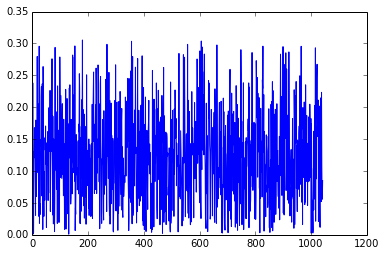

In [93]:
plt.plot(tau)

(array([ 24.,  22.,  24.,  24.,  27.,  18.,  23.,  16.,  22.,  33.,  25.,
         32.,  25.,  31.,  25.,  34.,  27.,  34.,  37.,  34.,  36.,  35.,
         28.,  32.,  38.,  30.,  27.,  18.,  19.,  26.,  22.,  17.,  18.,
         18.,  21.,  14.,   9.,  14.,  13.,   9.,   9.,   6.,   6.,   6.,
          1.,   9.,   8.,   3.,  10.,   3.]),
 array([ 0.00102266,  0.00711163,  0.01320059,  0.01928956,  0.02537853,
         0.0314675 ,  0.03755647,  0.04364543,  0.0497344 ,  0.05582337,
         0.06191234,  0.0680013 ,  0.07409027,  0.08017924,  0.08626821,
         0.09235717,  0.09844614,  0.10453511,  0.11062408,  0.11671305,
         0.12280201,  0.12889098,  0.13497995,  0.14106892,  0.14715788,
         0.15324685,  0.15933582,  0.16542479,  0.17151375,  0.17760272,
         0.18369169,  0.18978066,  0.19586962,  0.20195859,  0.20804756,
         0.21413653,  0.2202255 ,  0.22631446,  0.23240343,  0.2384924 ,
         0.24458137,  0.25067033,  0.2567593 ,  0.26284827,  0.26893724,
 

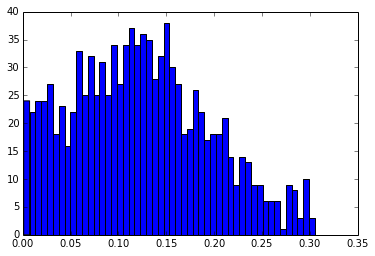

In [94]:
plt.hist(tau,bins=50)

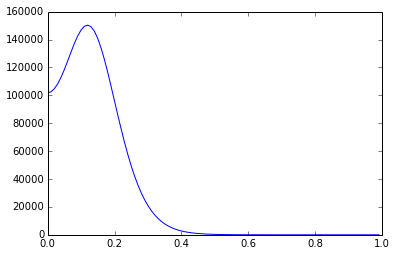

In [76]:
rang = np.arange(0,1,0.01)
dens=p_of_tau(y,sigma,rang)
plt.plot(rang,dens)

In [95]:
mu=np.random.normal(mu_hat(y,sigma,tau),np.sqrt(V_mu(sigma,tau)))

In [96]:
def Expectation_of_theta_j(y,sigma,tau):
    J=len(y)
    value=[]
    for j in range(J):
        value.append((tau**2*y[j]+sigma[j]**2*mu_hat(y,sigma,tau))/(sigma[j]**2+tau**2))
    return value

def std_of_theta_j(y,sigma,tau):
    J=len(y)
    value=[]
    for j in range(J):
        value.append(sigma[j]**2*tau**2/(sigma[j]**2+tau**2)+(sigma[j]**2/(sigma[j]**2+tau**2))**2*V_mu(sigma,tau))
    return np.sqrt(value)

In [97]:
E_of_theta_j=Expectation_of_theta_j(y,sigma,rang)
std_of_theta_j=std_of_theta_j(y,sigma,rang)

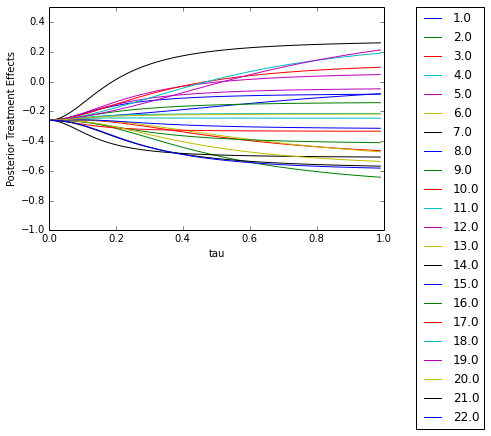

In [102]:
plt.xlabel("tau")
plt.ylabel("Posterior Treatment Effects")
plt.ylim([-1,0.5])
for i in range(len(data)):
    plt.plot(rang,E_of_theta_j[i],label=data.ix[i,0])
plt.legend(bbox_to_anchor=(1.3, 1.0), borderaxespad=0)

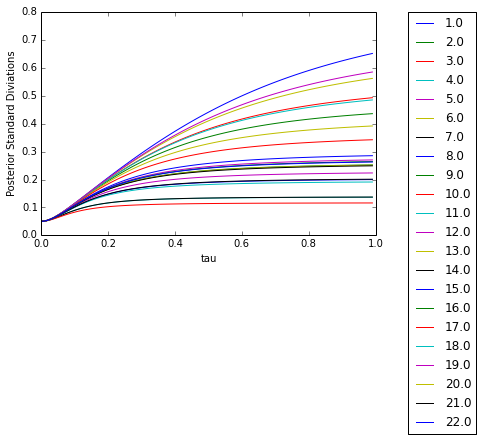

In [105]:
plt.xlabel("tau")
plt.ylabel("Posterior Standard Diviations")
plt.ylim([0,0.8])
for i in range(len(data)):
    plt.plot(rang,std_of_theta_j[i],label=data.ix[i,0])
plt.legend(bbox_to_anchor=(1.3, 1.0), borderaxespad=0)

In [108]:
def theta_j_hat(y,sigma,mu,tau):
    return (tau**2*y+sigma**2*mu)/(tau**2+sigma**2)

def V_j(sigma,tau):
    J=len(sigma)
    value=[]
    for j in range(J):
        value.append(sigma[j]**2*tau**2/(sigma[j]**2+tau**2))
    return value
        

def sampling_theta_j(y,sigma,mu,tau):
    theta_j_sim=[]
    for j in range(len(data)):
        value=[]
        for i in range(len(tau)):
            value.append(np.random.normal(theta_j_hat(y[j],sigma[j],mu,tau)[i],np.sqrt(V_j(sigma,tau)[j][i])))
        theta_j_sim.append(value)
    return theta_j_sim

theta_j_sim=sampling_theta_j(y,sigma,mu,tau)

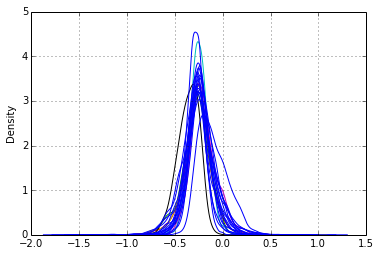

In [110]:
for j in range(len(data)):
    Series(theta_j_sim[j]).plot(kind="kde")

In [113]:
def summ(x,label):
    percentile=np.percentile(x,[2.5,25,50,75,97.5]).tolist()
    summ=[np.mean(x),np.std(x)]
    summ.extend(percentile)
    summ=DataFrame(summ,index=["mean","sd","2.5%","25%","50%","75%","97.5%"],columns=[label]).T
    return summ

for j in range(len(data)):
    print summ(theta_j_sim[j],data.ix[j,0])

      mean        sd      2.5%       25%      50%       75%     97.5%
1 -0.24033  0.151347 -0.510029 -0.328469 -0.24939 -0.162419  0.090475
       mean        sd      2.5%       25%       50%       75%     97.5%
2 -0.284282  0.145781 -0.620326 -0.365008 -0.277278 -0.193836 -0.027563
       mean        sd      2.5%      25%      50%       75%     97.5%
3 -0.265667  0.144108 -0.584652 -0.34124 -0.26121 -0.186404  0.018294
       mean        sd      2.5%       25%       50%       75%     97.5%
4 -0.248245  0.095982 -0.437253 -0.311009 -0.251136 -0.190591 -0.057673
       mean        sd      2.5%       25%       50%       75%     97.5%
5 -0.197565  0.137367 -0.435135 -0.286487 -0.216091 -0.121679  0.125199
       mean        sd      2.5%       25%      50%       75%     97.5%
6 -0.268562  0.147762 -0.596996 -0.348196 -0.26446 -0.189388  0.012627
       mean        sd      2.5%       25%       50%       75%     97.5%
7 -0.357755  0.112757 -0.603553 -0.432959 -0.346251 -0.273681 -0.169956
  


        mean        sd      2.5%       25%       50%       75%     97.5%
14 -0.106793  0.152629 -0.331163 -0.223866 -0.129937 -0.007054  0.213665
       mean        sd      2.5%       25%       50%      75%     97.5%
15 -0.25958  0.133382 -0.557403 -0.337755 -0.261027 -0.18374  0.017151
        mean        sd      2.5%       25%       50%       75%     97.5%
16 -0.226072  0.128681 -0.463326 -0.306368 -0.236377 -0.159537  0.071572
        mean        sd      2.5%       25%       50%       75%     97.5%
17 -0.207269  0.144942 -0.470944 -0.298591 -0.225887 -0.126455  0.123889
        mean        sd      2.5%       25%       50%      75%     97.5%
18 -0.213193  0.157246 -0.498369 -0.310933 -0.229039 -0.13541  0.151693
        mean        sd      2.5%       25%       50%       75%    97.5%
19 -0.224748  0.158641 -0.537349 -0.314427 -0.234094 -0.141637  0.16368
        mean        sd      2.5%       25%       50%       75%     97.5%
20 -0.246479  0.125355 -0.483455 -0.319914 -0.251149 -0.17

In [115]:
print summ(mu,"mu")
print summ(tau,"tau")

        mean        sd      2.5%       25%       50%       75%     97.5%
mu -0.249429  0.065545 -0.373502 -0.294144 -0.249875 -0.204265 -0.122467
         mean        sd     2.5%       25%       50%       75%     97.5%
tau  0.123494  0.071274  0.00739  0.068557  0.120187  0.171633  0.279385


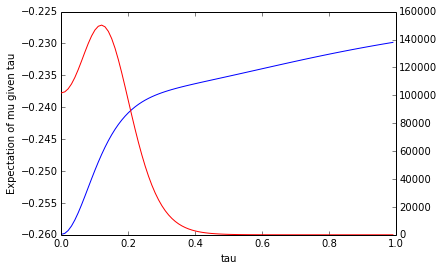

In [124]:
plt.xlabel("tau")
plt.ylabel("Expectation of mu given tau")
plt.plot(rang,mu_hat(y,sigma,rang))

ax = plt.twinx()
dens=p_of_tau(y,sigma,rang)
ax.plot(rang,dens,color="r")

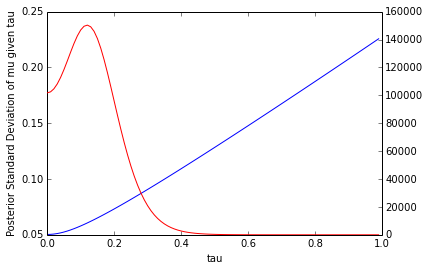

In [128]:
plt.xlabel("tau")
plt.ylabel("Posterior Standard Deviation of mu given tau")
plt.plot(rang,np.sqrt(V_mu(sigma,rang)))

ax = plt.twinx()
dens=p_of_tau(y,sigma,rang)
ax.plot(rang,dens,color="r")

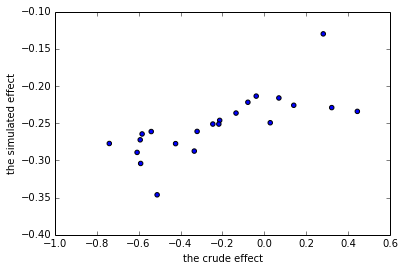

In [133]:
#EXERCISE 5.15 (c)
median_of_theta_j=[]
for j in range(len(theta_j_sim)):
    median_of_theta_j.append(np.percentile(theta_j_sim[j],50))

plt.xlabel("the crude effect")
plt.ylabel("the simulated effect")
plt.scatter(y,median_of_theta_j)

(array([   2.,    3.,    0.,    5.,    4.,    4.,    6.,   10.,    7.,
           8.,    6.,   13.,   20.,   19.,   26.,   29.,   42.,   52.,
          60.,   79.,   76.,   76.,  100.,   65.,   69.,   51.,   43.,
          30.,   25.,   22.,   20.,   11.,    9.,   11.,    6.,   10.,
           2.,    6.,    4.,    2.,    4.,    0.,    1.,    1.,    1.,
           0.,    0.,    0.,    1.,    1.]),
 array([-0.74474894, -0.72205796, -0.69936697, -0.67667599, -0.65398501,
        -0.63129402, -0.60860304, -0.58591206, -0.56322107, -0.54053009,
        -0.51783911, -0.49514812, -0.47245714, -0.44976616, -0.42707517,
        -0.40438419, -0.38169321, -0.35900222, -0.33631124, -0.31362026,
        -0.29092927, -0.26823829, -0.24554731, -0.22285632, -0.20016534,
        -0.17747436, -0.15478337, -0.13209239, -0.10940141, -0.08671042,
        -0.06401944, -0.04132846, -0.01863747,  0.00405351,  0.02674449,
         0.04943548,  0.07212646,  0.09481744,  0.11750843,  0.14019941,
         0.16289

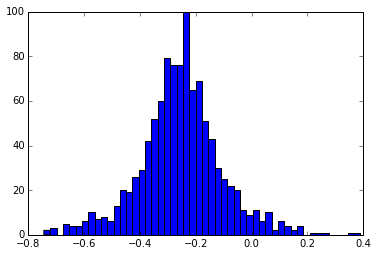

In [135]:
#(d)
theta_j_tilde=np.random.normal(mu,tau)
plt.hist(theta_j_tilde,bins=50)